# El objetivo es utilizar la técnica de Q-learning para entrenar a un agente en The Taxi Problem. En este problema, hay cuatro ubicaciones designadas para recoger y dejar pasajeros (Rojo, Verde, Amarillo y Azul) en una cuadrícula de 5x5. El taxi comienza en una casilla aleatoria y el pasajero en una de las ubicaciones designadas. El objetivo es mover el taxi hasta la ubicación del pasajero, recoger al pasajero, llevarlo a su destino y dejarlo en el lugar indicado. El jugador recibe recompensas positivas por dejar al pasajero correctamente en su destino. También recibe recompensas negativas por intentos fallidos de recoger o dejar al pasajero.

In [ ]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.7 MB/s eta 0:00:00


Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [ ]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero. '|' representa una pared que el taxi no puede cruzar, es decir. R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [ ]:
# Una semilla diferente
semilla = 3

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Exploremos el espacio de estados y de acciones:

In [ ]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Espacio de Acciones Discrete(6)
Espacio de Estados Discrete(500)


Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacie arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [ ]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [ ]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        """Aprender a partir de la tupla
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

In [ ]:
def ejecutar_episodio(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0
    recompensa_acumulada = 0

    marcos = [] # Para la animación

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        recompensa_acumulada += recompensa

        # Se agrega cada frame al diccionario para animación
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )
        #

        estado_anterior = estado_siguiente
        iteraciones += 1

    return iteraciones, penalizaciones, recompensa_acumulada

Definimos un agente aleatorio que no aprenda:

In [ ]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [ ]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []
penalizaciones_episodios = []
recompensa_por_paso_episodios = []
for i in range(100):
    num_iteraciones, penalizaciones, recompensa_acumulada = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    penalizaciones_episodios += [penalizaciones]
    recompensa_por_paso_episodios += [recompensa_acumulada / num_iteraciones]

Y obtener métricas al respecto

In [ ]:
import numpy
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)} iteraciones, en promedio")
print(f"Se recibieron {numpy.mean(penalizaciones_episodios)} penalizaciones, en promedio")
print(f"El promedio de la recompensa por paso de todos los episodios es: {numpy.mean(recompensa_por_paso_episodios)}")

Se realizaron 2247.99 iteraciones, en promedio
Se recibieron 727.56 penalizaciones, en promedio
El promedio de la recompensa por paso de todos los episodios es: -3.859160096700046


A continución definiremos un agente con capacidad de aprendizaje con el fin de mejorar su rendimiento. Para ello, haremos uso de una matriz Q de tamaño 500x6 (500 posibles estados y 6 acciones posibles), inicializada con ceros, donde los valores de cada entrada representan la utilidad esperada de tomar una acción específica en un estado dado. El proceso de aprendizaje se lleva a cabo de la siguiente manera:


*   Inicialización: Se inicializan los valores del factor de descuento ($γ$) y el factor de exploración ($ϵ$).
*   Selección de acción: En cada paso de tiempo, el agente selecciona una acción basándose en una estrategia epsilon-greedy. Con una probabilidad $ϵ$, elige una acción aleatoria para explorar el entorno; de lo contrario, elige la acción con el valor $Q$ más alto para explotar el conocimiento adquirido.
*   Actualización de la tabla $Q$: Después de realizar una acción y observar la recompensa y el nuevo estado, el agente actualiza los valores Q utilizando la fórmula de actualización de Q-learning: $Q(s,a)  \leftarrow r(s,a) + \gamma * máx Q(s',a')$, donde:

  *   $s$ es el estado actual.
  *   $a$ es la acción realizada.
  *   $r(s,a)$ es la recompensa obtenida al realizar la acción a en el estado s
  *   $s'$ es el nuevo estado después de realizar la acción.
  *   $a'$ es una de las 6 acciones posibles.
  *   $γ$ es el factor de descuento.








In [ ]:
import numpy as np
import random

class AgenteRL(Agente):

    def __init__(self, entorno) -> None:
        super().__init__()
        self.gamma = 0.1 # factor de descuento
        self.epsilon = 0.1

        # Q-table para cada (estado, accion) da el Q valor
        # Tamaño 500 x 6
        # Se inicializa con 0s
        self.tabla = {}
        for estado in range(500):
            self.tabla[estado] = {}
            for accion in range(6):
                self.tabla[estado][accion] = 0

        self.tabla_p4 = {}

    def guardar_tabla(self):
      self.tabla_p4 = self.tabla

    def restaurar_tabla(self):
      self.tabla = self.tabla_p4

    def sin_visitar(self):
      cantidad = 0
      for estado in range(500):
        for accion in range(6):
          if (self.tabla[estado][accion] == 0):
            cantidad = cantidad + 1
      return cantidad

    def get_tabla(self):
      return self.tabla

    def elegir_accion(self, estado, max_accion) -> int:
        # Epsilon-Greedy:
        # con prob ∈ se Explora, en caso contrario se Explota
        accion = 0
        if random.random() < self.epsilon:
          # Exploración: elige una acción aleatoria
          accion = random.randint(0, max_accion - 1)
        else:
        # Explotación: elige la acción con el valor estimado más alto
          mejor_accion = 0
          mejor_recompensa = self.tabla[estado][mejor_accion]
          for accion_posible in range(1, max_accion):
            if self.tabla[estado][accion_posible] > mejor_recompensa:
              mejor_accion = accion_posible
              mejor_recompensa = self.tabla[estado][accion_posible]
          accion = mejor_accion

        return accion

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        mejor_accion = 0
        mejor_recompensa = self.tabla[estado_siguiente][mejor_accion]
        for accion_posible in range(1, 6):
          if self.tabla[estado_siguiente][accion_posible] > mejor_recompensa:
            mejor_accion = accion_posible
            mejor_recompensa = self.tabla[estado_siguiente][accion_posible]

        self.tabla[estado_anterior][accion] = recompensa + self.gamma * mejor_recompensa


Se ejecuta 100 episodios con la misma semilla y se obtienen métricas:

In [ ]:
import numpy
agente = AgenteRL(entorno)
semilla = 1
num_iteraciones_episodios = []
penalizaciones_episodios = []
recompensa_por_paso_episodios = []
for i in range(100):
    num_iteraciones, penalizaciones, recompensa_acumulada = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    penalizaciones_episodios += [penalizaciones]
    recompensa_por_paso_episodios += [recompensa_acumulada / num_iteraciones]

print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)} iteraciones, en promedio")
print(f"Se recibieron {numpy.mean(penalizaciones_episodios)} penalizaciones, en promedio")
print(f"El promedio de la recompensa por paso de todos los episodios es: {numpy.mean(recompensa_por_paso_episodios)}")

Se realizaron 42.8 iteraciones, en promedio
Se recibieron 3.14 penalizaciones, en promedio
El promedio de la recompensa por paso de todos los episodios es: 0.19465421717956333


# Definiendo parámetros del agente:

Una vez que creado el agente, antes de emplearlo, se determinará qué valores adoptarán los parámetros $\gamma$ y $\epsilon$. Para eso, se compararan las ejecuciones utilizando los promedios de iteraciones, penalizaciones y recompensas por paso, evaluados en 1000 episodios (con una semilla establecida en 1).

Promedio  iteraciones:

|gamma\epsilon| 0.7 | 0.4 | 0.3 |  0.1 |
|---|---|---|---|---|
|0.9| 245.742 | 270.618 | 325.69 | 848.057 |
|0.8| 176.348 | 200.033 | 237.097 | 583.622 |
|0.7| 140.412 | 139.52  | 167.746 | 411.492 |
|0.6| 116.31 | 106.821 | 130.436 | 316.602 |
|0.5| 98.648  | 77.627 | 90.226 | 187.773 |
|0.1| 68.998 | 30.646 | 26.392 | 18.22 |

Promedio penalizaciones:

|gamma\epsilon| 0.7 | 0.4 | 0.3 | 0.1 |
|---|---|---|---|---|
|0.9| 67.776 | 80.485 | 101.919 | 288.786 |
|0.8| 40.205 | 33.379 | 34.396 | 69.108 |
|0.7| 29.507 | 16.39  | 14.616 | 12.015 |
|0.6| 25.403 | 13.659 | 12.577 | 10.676 |
|0.5| 21.844 | 10.151 |  8.89 | 6.317 |
|0.1| 14.981 | 3.81 |  2.598 | 0.704 |

Promedio recompensa por paso:

|gamma\epsilon| 0.7 | 0.4 | 0.3| 0.1 |
|---|---|---|---|---|
|0.9| -3.3477852698839694 | -3.613231866146435 | -3.76060694757402 | -4.206595067798411 |
|0.8|  -2.9304408027608844 | -2.5441470560676325 | -2.390162917554132 | -2.599911874883949 |
|0.7|  -2.6502495103385244 | -1.7563092178807302  |  -1.5252514658582272 |-1.1071874958779444 |
|0.6| -2.6552184365832137 | -1.763847200715347 |  -1.5207334018551515 | -1.0879042170807016 |
|0.5| -2.6629314230151704 | -1.7213518408783393 | -1.456784380384543 | -1.00892831205213 |
|0.1| -2.474775989692254 | -1.08690699043825 | -0.6584442816362513 | 0.30484284857164884 |

Además, se ejecutaron pruebas con $\epsilon$ decreciente, una técnica comúnmente utilizada para explorar más al principio y, a medida que se aprende, reducir la exploración y aprovechar el conocimiento adquirido.

Se probó decreciendo en incrementos de 0.001 hasta alcanzar un límite inferior de 0.1. Los resultados obtenidos fueron los siguientes:

|gamma| iteraciones | penalizaciones | recompensa por paso |
|---|---|---|--- |
|0.9| 899.255 | 306.272 | -4.131152368845488 |
|0.8| 582.138 | 70.183 | -2.537010242203745 |
|0.7| 406.819 | 11.88 | -1.0994311544467872 |
|0.6| 279.485 | 9.498 | -1.0764667502474896 |
|0.5| 191.079 | 6.741 | -1.062652899059444 |
|0.4| 92.152 | 3.301 | -0.7908089397681026 |
|0.3| 78.04   | 2.838 | -0.7443715373103262 |
|0.2| 22.2    | 0.986 |  0.253289958508605  |
|0.1| 19.196  | 0.933 |  0.27047374289570586|
|0.05| 76.437 | 2.694 | -0.7395249825876712 |

Después de todas las pruebas realizadas, los resultados más prometedores se obtuvieron con $\gamma$=0.1 y $\epsilon$ fijo en 0.1. Por lo tanto, en las próximas etapas, se utilizaran estos valores. A continuación, se muestra un gráfico que representa la cantidad de iteraciones necesarias para alcanzar el objetivo en cada uno de los primeros 100 episodios ejecutados.

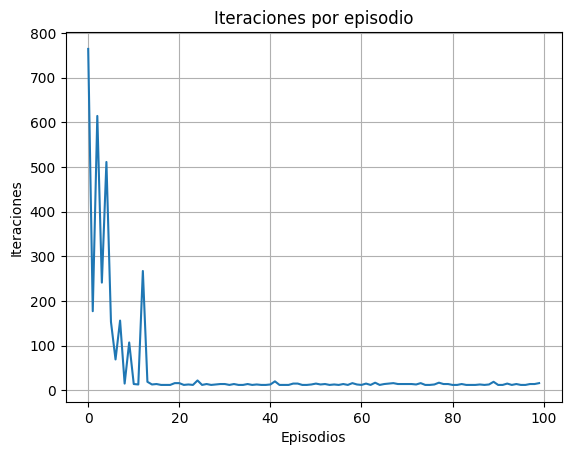

In [ ]:
import matplotlib.pyplot as plt
# Crear el gráfico de líneas
plt.plot(num_iteraciones_episodios[0:100])
plt.xlabel('Episodios')
plt.ylabel('Iteraciones')
plt.title('Iteraciones por episodio')
plt.grid(True)
# Mostrar el gráfico
plt.show()

# Rendimiento con otra semilla:

Para evaluar el agente con otra semilla, se elige una diferente a la semilla 1 (con distinto origen y destino). Se opta por utilizar la semilla 46.

In [ ]:
semilla = 46
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [ ]:
semilla = 46
num_iteraciones_episodios = []
penalizaciones_episodios = []
recompensa_por_paso_episodios = []
for i in range(1000):
    num_iteraciones, penalizaciones, recompensa_acumulada = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    penalizaciones_episodios += [penalizaciones]
    recompensa_por_paso_episodios += [recompensa_acumulada / num_iteraciones]

print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)} iteraciones, en promedio")
print(f"Se recibieron {numpy.mean(penalizaciones_episodios)} penalizaciones, en promedio")
print(f"El promedio de la recompensa por paso de todos los episodios es: {numpy.mean(recompensa_por_paso_episodios)}")

Se realizaron 20.867 iteraciones, en promedio
Se recibieron 0.828 penalizaciones, en promedio
El promedio de la recompensa por paso de todos los episodios es: -0.10468160561718347


Como el destino es diferente, ninguna entrada de la matriz Q con este destino fue completada en las iteraciones realizadas anteriormente. Por lo tanto, es esperable que no se aprecien mejoras en las métricas, pues el conocimiento adquirido tras entrenar con la semilla 1 no es de utilidad cuando se utiliza la semilla 46.

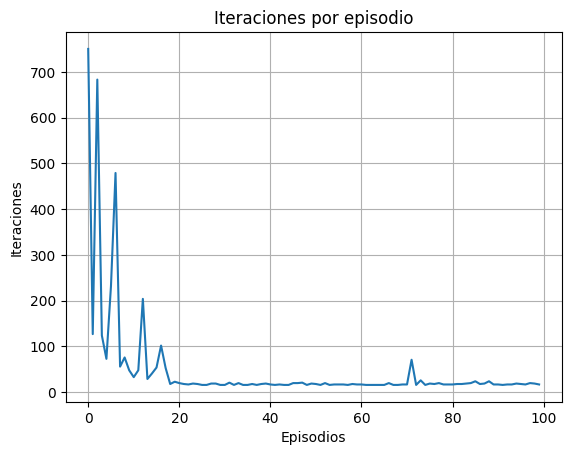

In [ ]:
# Crear el gráfico de líneas
plt.plot(num_iteraciones_episodios[0:100])
plt.xlabel('Episodios')
plt.ylabel('Iteraciones')
plt.title('Iteraciones por episodio')
plt.grid(True)
# Mostrar el gráfico
plt.show()

# Mejora del agente:

In [ ]:
import matplotlib.pyplot as plt
import numpy
agente = AgenteRL(entorno)
semilla = 1
num_iteraciones_episodios = []
penalizaciones_episodios = []
recompensa_por_paso_episodios = []
for i in range(1000):
    num_iteraciones, penalizaciones, recompensa_acumulada = ejecutar_episodio(agente, semilla)
ceros = agente.sin_visitar()
print("Entradas sin visitar: " + str(ceros));

Entradas sin visitar: 2400


Respecto a la exploración, se pudo apreciar que, una vez ejecutados los mil episodios, se completaron 600 de las 3000 celdas posibles de la matriz Q, dejando 2400 con valor 0. Incluso si  ϵ  valiera 1, donde el agente buscaría explorar en toda iteración, y nunca aprender, la máxima cantidad de celdas posibles a completar serían 600. Por lo tanto, con el  ϵ  seleccionado anteriormente, se concluye que el agente explora todas las opciones posibles para la semilla elegida.

Las 600 celdas completadas, dada la semilla seleccionada, se debe a que existen 25 posiciones diferentes para el taxi, 4 posiciones diferentes para el pasajero (3 de los 4 posibles lugares de origen, y adicionalmente cuando se encuentra dentro del taxi), 1 posición de destino que no varía durante el transcurso de las ejecuciones, y 6 acciones diferentes a tomar en cada estado. Se utilizará un ejemplo para poder explicar lo mencionado anteriormente, suponiendo que el pasajero comienza en B, y el lugar de destino es R. Dadas estas circunstancias, el taxi puede moverse por las diferentes 25 posiciones (con el taxi sin el pasajero) y realizar en cada una de ellas 6 acciones diferentes. Adicionalmente, el taxista podría recoger al pasajero en B, y llevarlo hacia G o Y, para posteriormente hacer un “dropoff”. Luego, con el pasajero en G o Y, podría moverse por las 25 posiciones y realizar otra vez, las 6 acciones en cada posición. Por último, el taxista podría recoger al pasajero, y con él adentro, moverse por las 25 posiciones, realizando las 6 acciones en cada una. El taxista no sería capaz de hacer un “dropoff” (con el pasajero dentro del taxi) en R y luego continuar moviéndose, pues, en ese caso, el pasajero llegaría a destino y el episodio finalizaría.

Teniendo en cuenta que solo fueron completadas 600 entradas para una semilla y como se menciona en la sección anterior, esta información no es de utilidad para una nueva semilla con un destino diferente, una posible solución para mejorar el desempeño del agente ante una semilla arbitraria, sería "entrenar" lo suficiente el agente con distintas semillas hasta completar cierto umbral de entradas de la matriz Q.

La situación ideal sería poder cubrir el 100% de las entradas de la matriz, pero tras algunas pruebas, se observa que el tiempo requerido para completar más del 80% aumenta considerablemente.

In [ ]:
agente = AgenteRL(entorno)
# Q-table tiene tamaño 500 x 6
# El objetivo es completar el 80% de la Q-table
# Queda el 20% sin visitar
semillas = []
umbral = 500 * 6 * 0.20
episodios = 100
while (agente.sin_visitar() > umbral):
  semilla = random.randint(1, 1000)
  semillas.append(semilla)
  for i in range(episodios):
    num_iteraciones, penalizaciones, recompensa_acumulada = ejecutar_episodio(agente, semilla)

agente.guardar_tabla()
print(f"Semillas utilizadas {semillas}")

Semillas utilizadas [110, 700, 769, 856, 398, 683, 734, 152, 243, 678, 697, 553]


Con este agente, que tiene cubierto al menos 80% de sus entradas, se prueba su rendimiento con 10 semillas arbitrarias y se lo compara con un agente nuevo sin entrenamiento previo.

In [ ]:
semillas = []
primeras_ocurr_entrenado = []
primeras_ocurr_nuevo = []
for i in range(10):
  semilla = random.randint(1, 1000)
  semillas.append(semilla)
  agente.restaurar_tabla()
  agente_nuevo = AgenteRL(entorno)
  iteraciones_entrenado = []
  iteraciones_nuevo = []

  for i in range(1000):
      num_iteraciones_nuevo, penalizaciones_nuevo, recompensa_acumulada_nuevo = ejecutar_episodio(agente_nuevo, semilla)
      iteraciones_nuevo.append(num_iteraciones_nuevo)
      num_iteraciones_entrenado, penalizaciones_entrenado, recompensa_acumulada_entrenado = ejecutar_episodio(agente, semilla)
      iteraciones_entrenado.append(num_iteraciones_entrenado)


  min_iteraciones_nuevo = min(iteraciones_nuevo)
  primera_ocurr_nuevo = iteraciones_nuevo.index(min_iteraciones_nuevo) + 1
  primeras_ocurr_nuevo.append(primera_ocurr_nuevo)

  min_iteraciones_entrenado = min(iteraciones_entrenado)
  primera_ocurr_entrenado = iteraciones_entrenado.index(min_iteraciones_entrenado) + 1
  primeras_ocurr_entrenado.append(primera_ocurr_entrenado)

In [ ]:
print(f"semillas {semillas}")
print(f"primeras_ocurr_nuevo {primeras_ocurr_nuevo}")
print(f"primeras_ocurr_entrenado {primeras_ocurr_entrenado}")

semillas [331, 827, 696, 792, 502, 540, 65, 214, 223, 503]
primeras_ocurr_nuevo [10, 17, 17, 28, 15, 19, 12, 13, 24, 26]
primeras_ocurr_entrenado [2, 10, 1, 2, 2, 1, 5, 1, 14, 11]


Tras entrenar con las  semillas [734, 361, 671, 662, 429, 813] (1000 iteraciones con cada una), se crea una tabla que compara para 10 semillas arbitrarias cuando se produjo el primer episodio con la mínima cantidad de iteraciones tanto con el agente sin entrenar como con el agente entrenado.

|Semilla arbitraria| Agente sin entrenar | Agente entrenado |
|---|---|---|
|12  |26 |17 |
|757 |17 |16 |
|663 |29 |7  |
|283 |19 |14 |
|879 |16 |2  |
|720 |23 |2  |
|192 |29 |3  |
|324 |12 |4  |
|567 |29 |7  |
|721 |16 |6  |

Puede observarse que para todas las semillas con las que se probó hubo una mejora en la cantidad de episodios que tardó en llegar al mínimo con el agente entrenado.